In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2124,1.089798,0.192936,1cb6bc89
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2673,1.449414,0.200012,1c580245
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2673,1.792392,0.203876,7a9a4a92
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3338,2.094256,0.205078,284e4fa3
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,706,0.298440,0.212681,392df4b8
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,5,180,0.077502,0.210617,10c782bc
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,5,265,0.137281,0.214012,41fbf675
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,5,265,0.169709,0.216423,7dc89cda
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,5,323,0.225399,0.214241,56507e48
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,5,356,0.133103,0.222397,3a6de90d


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("5-value-iterations.pkl.gz")
df

100%|███████████████████████████████████████████| 80/80 [05:39<00:00,  4.24s/it]


,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2124,...,0.33,1,0.000998,0.001,1429,0,8.887045,35.829443,98.128231,0.365129
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2673,...,0.33,1,0.000998,0.001,1622,0,12.908203,43.723181,98.296451,0.444809
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2673,...,0.33,1,0.000998,0.001,1300,0,9.364458,30.915383,98.088653,0.315178
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3338,...,0.33,1,0.000999,0.001,1167,0,10.431051,33.658254,98.120057,0.343031
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,706,...,0.33,1,0.000999,0.001,1262,0,2.171170,31.525457,96.716070,0.325959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,w/ both,generic_1,bitcoin,True,True,True,True,False,5,115,...,0.66,1,0.000997,0.001,1380,0,0.563514,98.902662,98.902662,1.000000
76,w/ both,generic_1,ethereum_3,True,True,True,True,False,5,167,...,0.66,1,0.000993,0.001,1380,0,0.788043,98.902662,98.902662,1.000000
77,w/ both,generic_1,byzantium_3,True,True,True,True,False,5,167,...,0.66,1,0.000993,0.001,1380,0,0.797292,98.902662,98.902662,1.000000
78,w/ both,generic_1,ghostdag_3,True,True,True,True,False,5,174,...,0.66,1,0.000993,0.001,1378,0,0.848166,98.901678,98.901678,1.000000


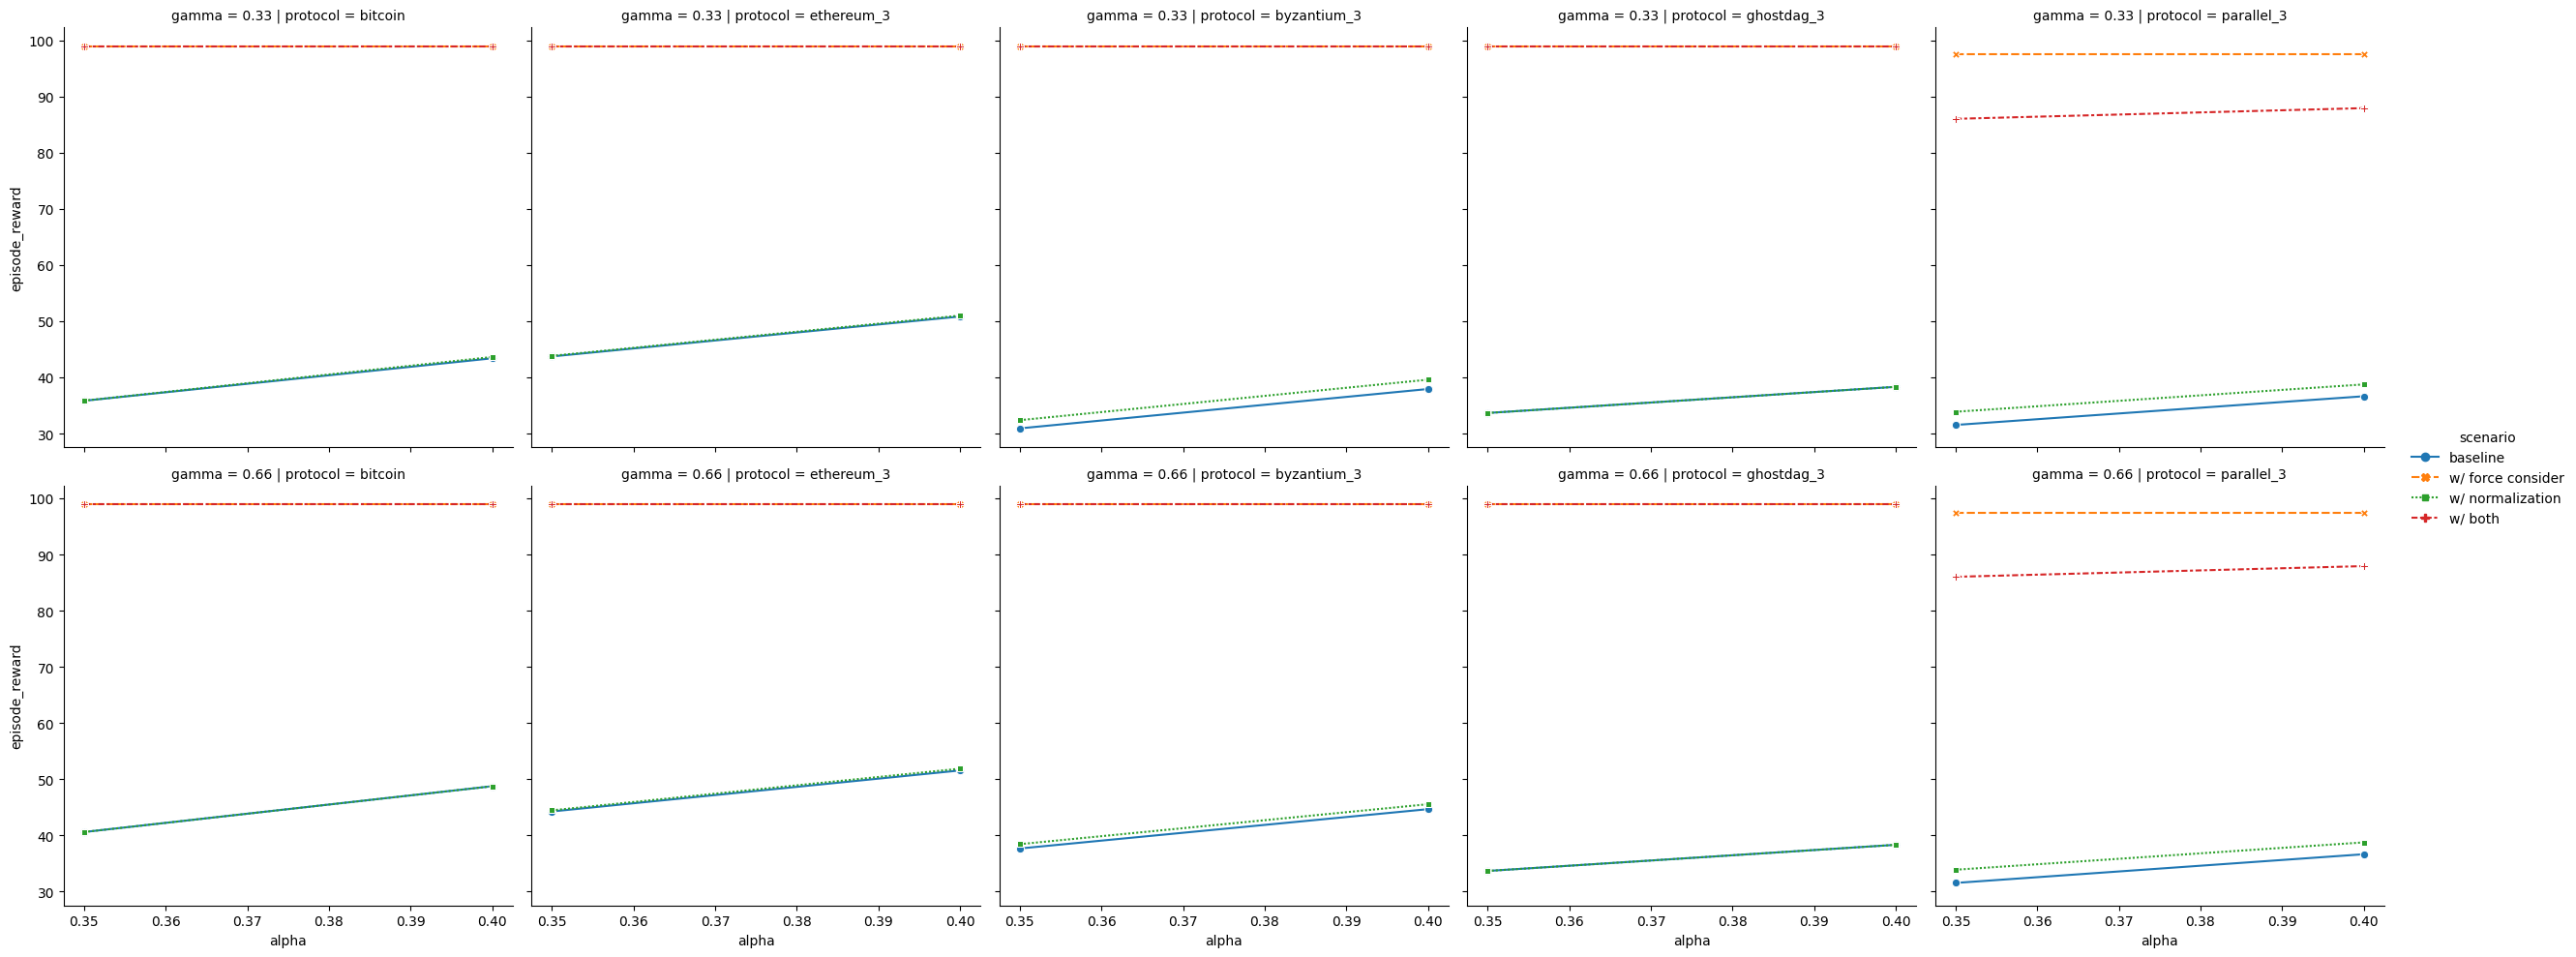

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

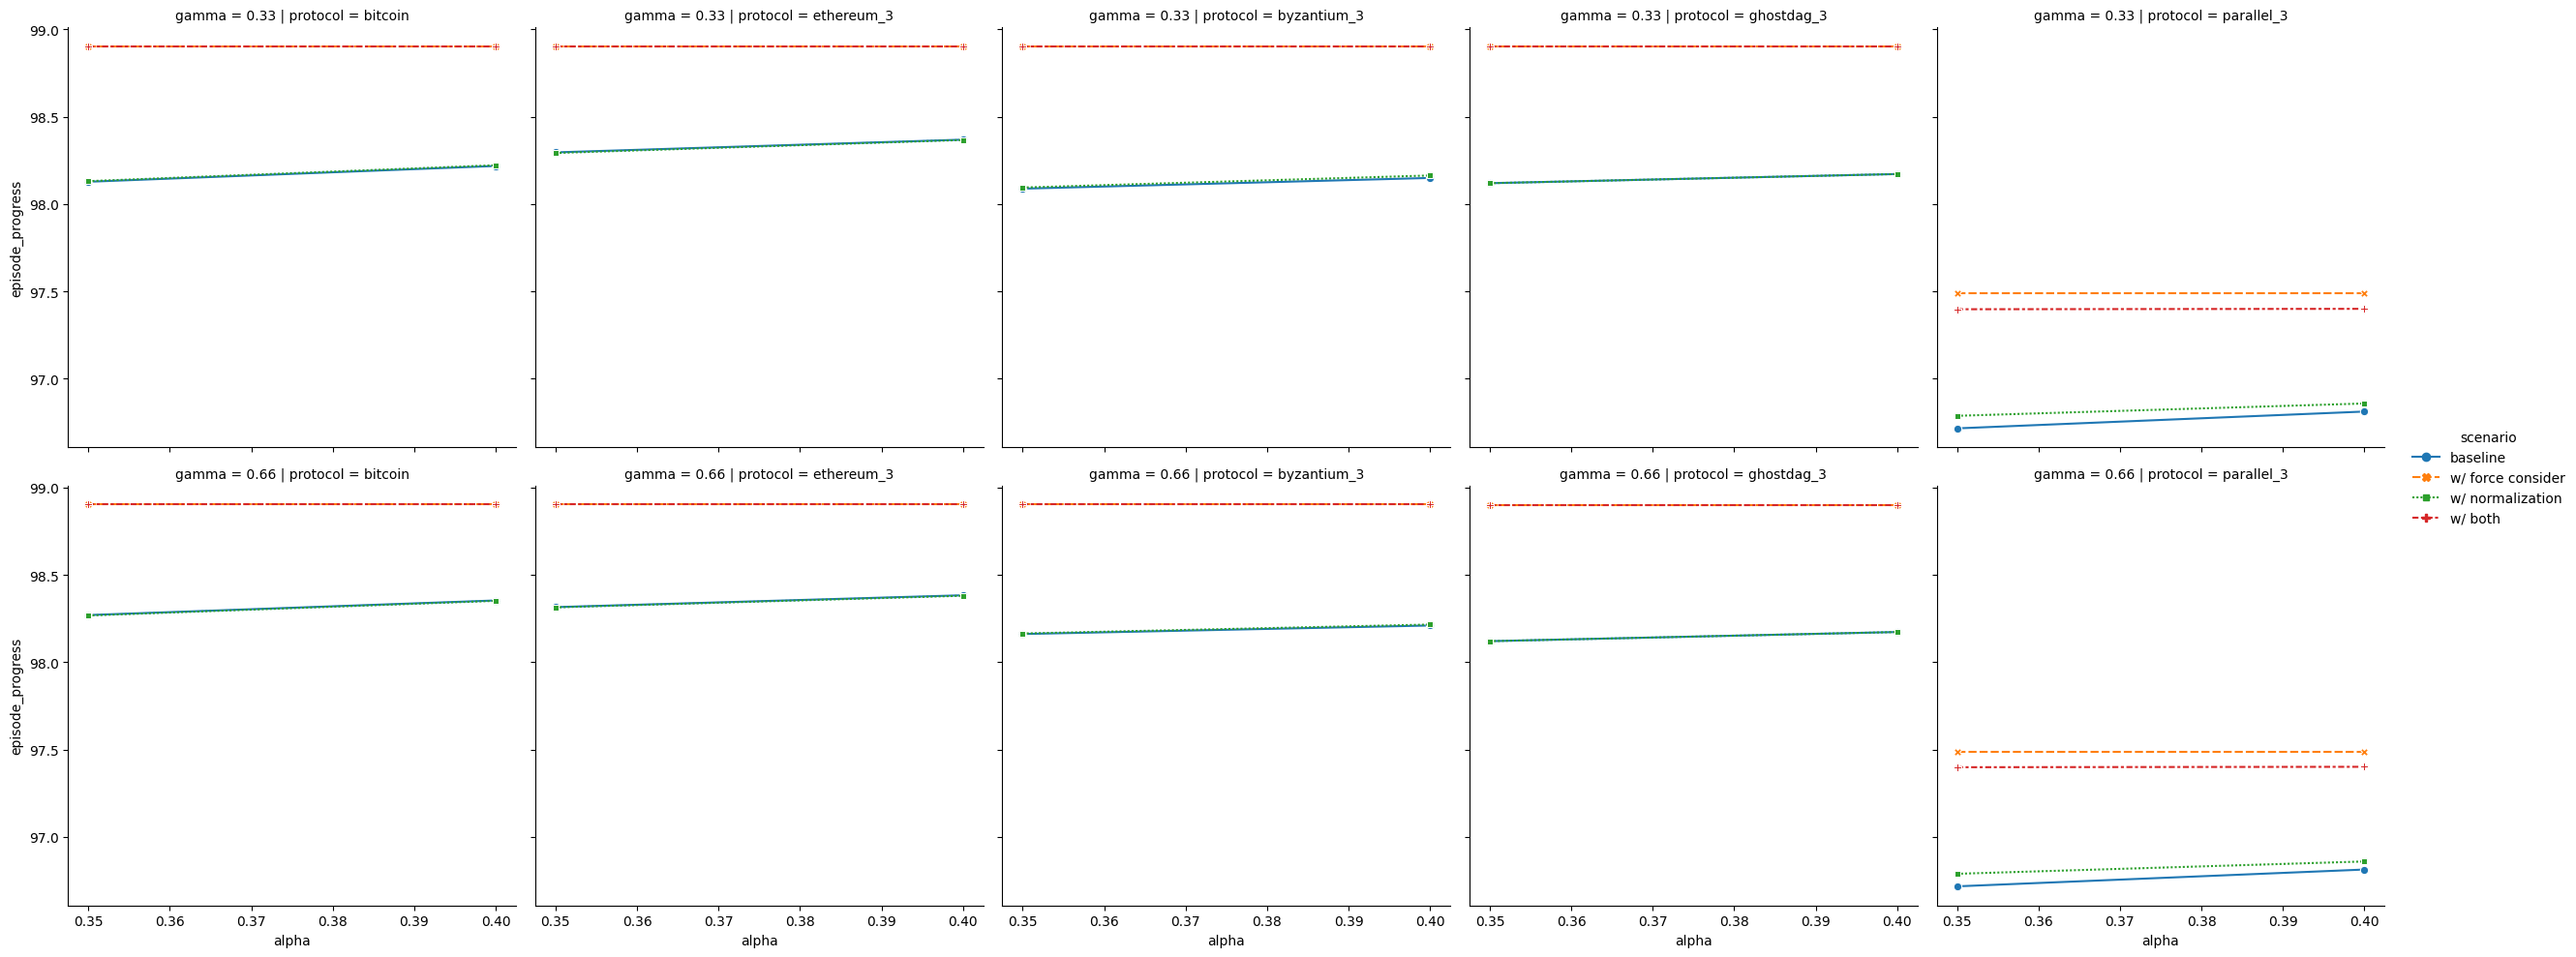

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

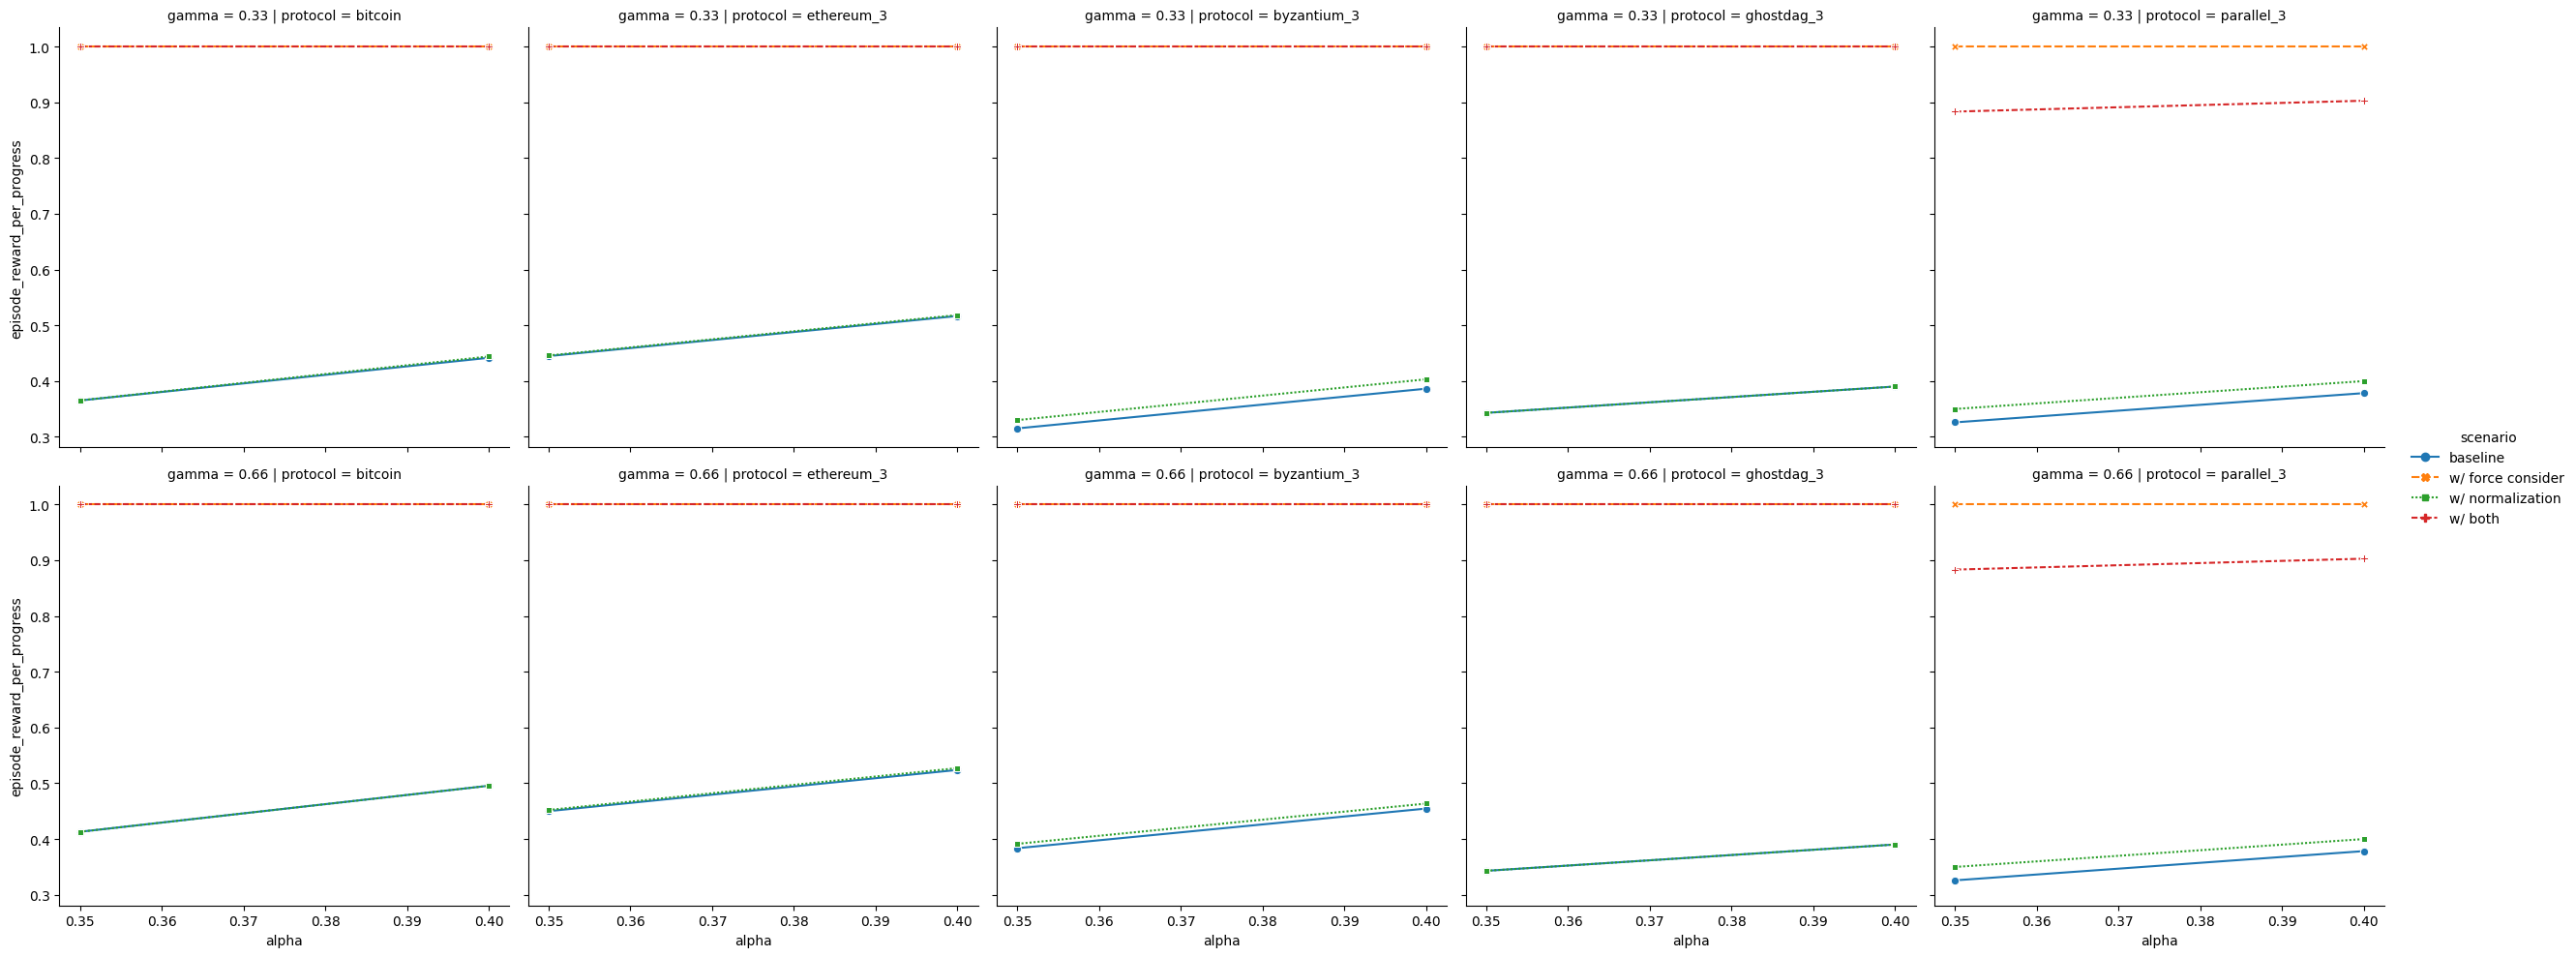

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

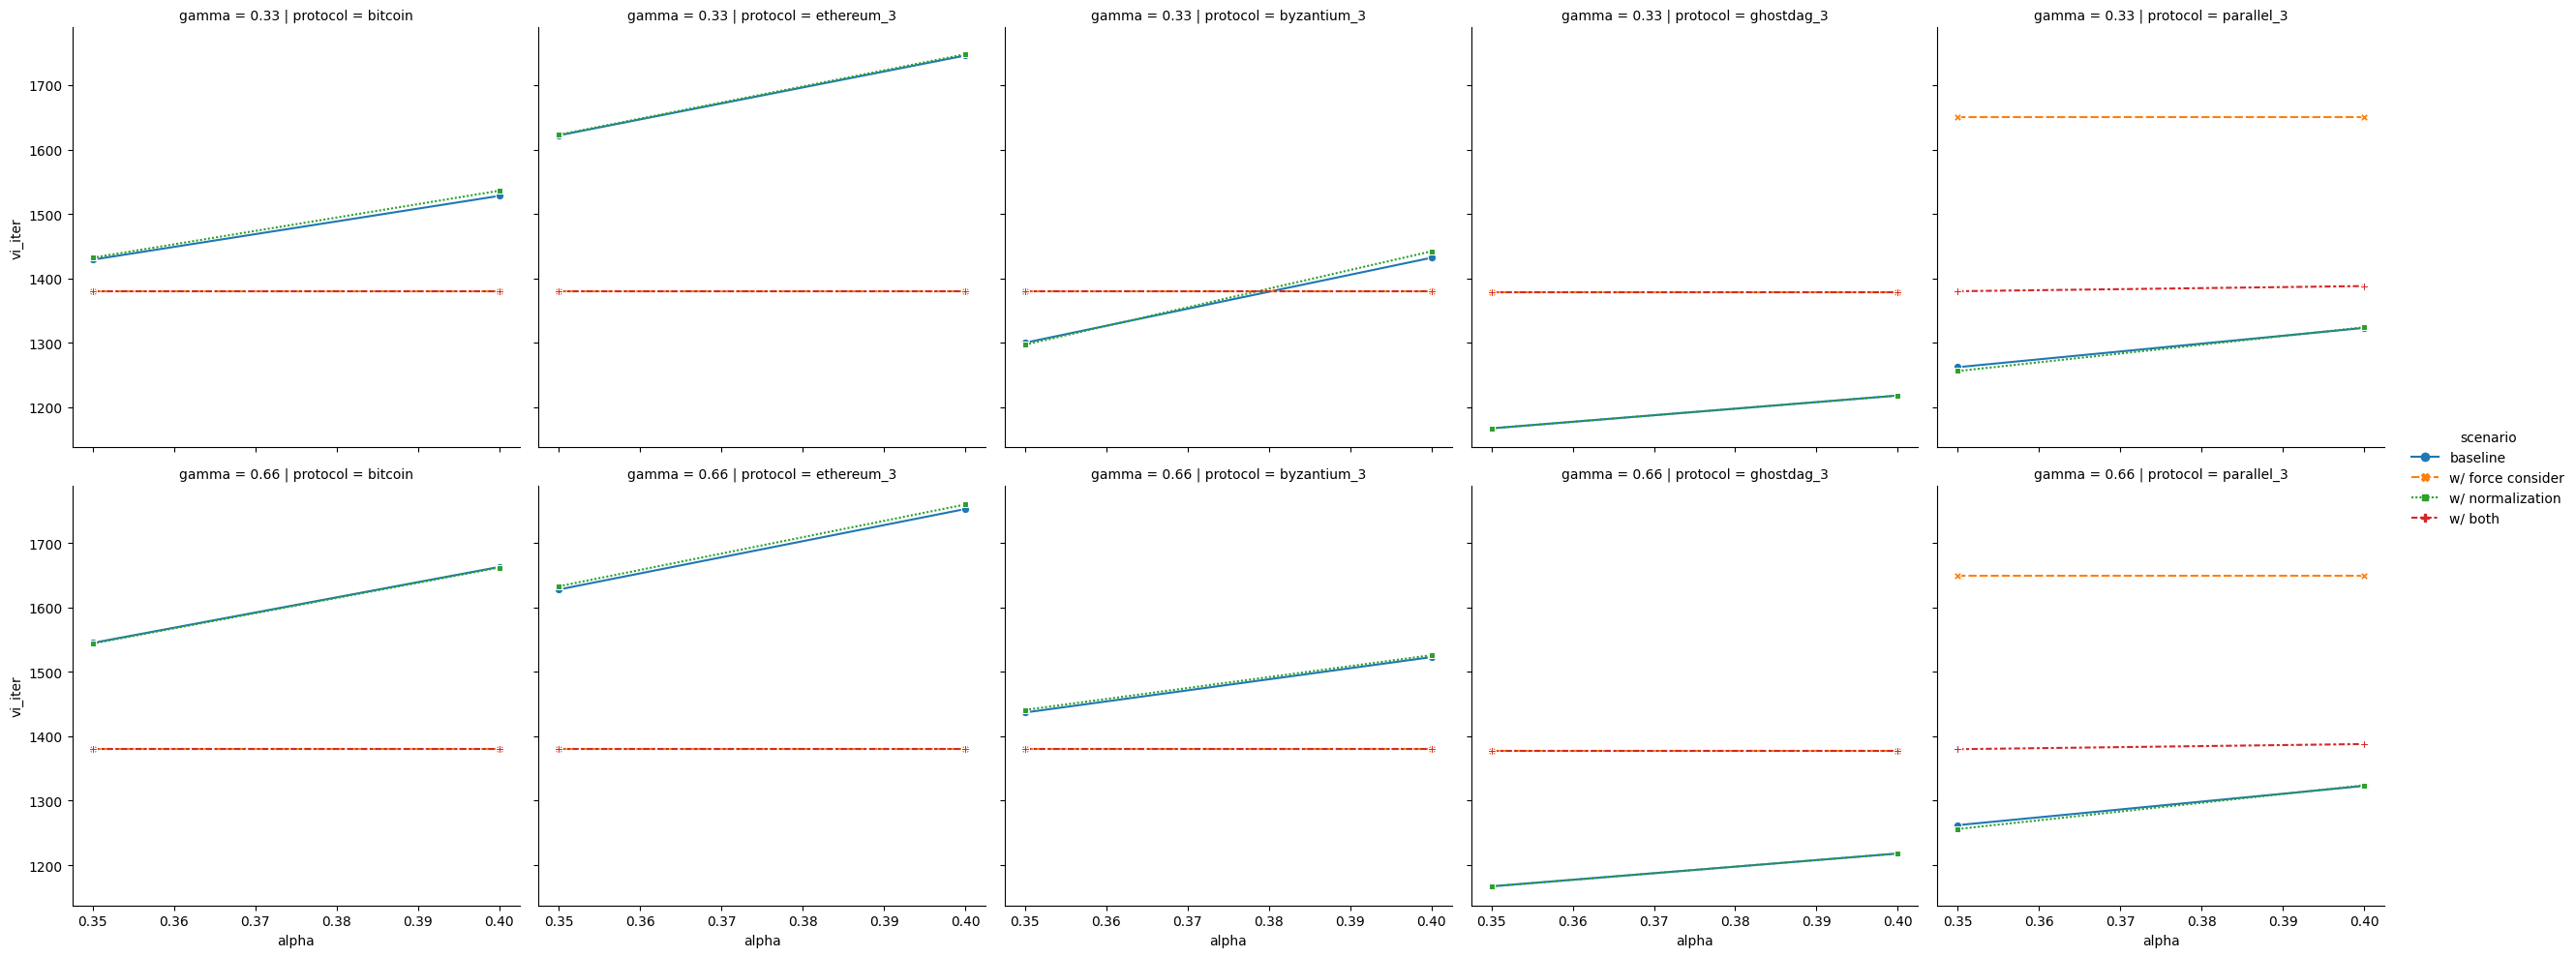

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)